# Assembling TUSV-ext input from Sarek Output

In [21]:
# Working version, unfortunately now needs to have static SV identity


import pandas as pd
import numpy as np
import os
import gzip
from io import StringIO
import re
import sys
from Bio import SeqIO
import pandas as pd
import logging
from datetime import datetime


# Define global variables
cnv_count = 1
sv_count = 1
snv_count = 1

def increment_cnv():
    global cnv_count
    cnv_count += 1

def increment_sv():
    global sv_count
    sv_count += 1

def increment_snv():
    global snv_count
    snv_count += 1

def convert_chromosome(chrom):
    if chrom == 'chrX' or chrom == 'X':
        return "23"
    elif chrom == "chrY" or chrom == 'Y':
        return "24"
    elif chrom.startswith('chr'):
        return str(chrom[3:])
    else:
        return str(chrom)

def init_vcf(output_folder, sample):
    output_file_path = os.path.join(output_folder, sample + '.vcf')
    with open(output_file_path, 'w') as file_vcf:
        file_vcf.write('##fileformat=VCFv4.2\n')
        file_vcf.write('##filedate=20211011\n')
        file_vcf.write('##INFO=<ID=END,Number=1,Type=Integer,Description="End position of the variant described in this record">\n')
        file_vcf.write('##INFO=<ID=IMPRECISE,Number=0,Type=Flag,Description="Imprecise structural variation">\n')
        file_vcf.write('##INFO=<ID=MATEID,Number=.,Type=String,Description="ID of mate breakends">\n')
        file_vcf.write('##INFO=<ID=SVTYPE,Number=1,Type=String,Description="Type of structural variant">\n')
        file_vcf.write('##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n')
        file_vcf.write('##FORMAT=<ID=CN,Number=2,Type=Integer,Description="Copy number genotype for imprecise events">\n')
        file_vcf.write('##FORMAT=<ID=CNADJ,Number=.,Type=Float,Description="Copy number of adjacency">\n')
        file_vcf.write('##FORMAT=<ID=BDP,Number=1,Type=Integer,Description="Depth of split reads">\n')
        file_vcf.write('##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read depth">\n')
        file_vcf.write('##ALT=<ID=DEL,Description="Deletion">\n')
        file_vcf.write('##ALT=<ID=DUP,Description="Duplication">\n')
        file_vcf.write('##ALT=<ID=INS,Description="Insertion of novel sequence">\n')
        file_vcf.write('##ALT=<ID=CNV,Description="Copy number variable region">\n')
        file_vcf.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tTUMOR\tNORMAL\n')
    return output_file_path

def write_df_to_vcf(df, vcf_file):
    # Filter out rows where #CHROM column has the value 24
    # Ensure the #CHROM column is treated as a string
    df['#CHROM'] = df['#CHROM'].astype(str)
    
    # Perform the filtering operation
    filtered_df = df[df['#CHROM'] != '24']
    filtered_df.to_csv(vcf_file, sep='\t', mode='a', index=False, header=False)



def load_ascat_segment(file_path):
    """
    Reads an ASCAT output file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the ASCAT output file.

    Returns:
    pd.DataFrame: A DataFrame containing the ASCAT data.
    """
    # Define column names as specified in the example
    column_names = ['sample', 'chr', 'startpos', 'endpos', 'nMajor', 'nMinor']
    
    # Read the file into a DataFrame
    df = pd.read_csv(file_path, sep='\t', names=column_names, header=0)
    df['chr'] = df['chr'].apply(convert_chromosome)
    df = df[['chr', 'startpos', 'endpos', 'nMajor', 'nMinor']]
    return df

def load_ascat_cnv(file_path):
    """
    Reads an ASCAT output file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the ASCAT output file.

    Returns:
    pd.DataFrame: A DataFrame containing the ASCAT data.
    """
    # Define column names as specified in the example
    column_names = ['chr', 'startpos', 'endpos', 'nMajor', 'nMinor']
    
    # Read the file into a DataFrame
    df = pd.read_csv(file_path, sep='\t', names=column_names, header=0)
    df['chr'] = df['chr'].apply(convert_chromosome)
    return df


def convert_ascat_to_vcf_df(df, reference_genome_path):
    """
    Converts a DataFrame with ASCAT data to a VCF compatible DataFrame,
    adding rows for all segments of each chromosome that are not already in the data.
    """
    vcf_records = []
    chromosome_lengths = {}
    cnv_count = 0



    # Parse the reference genome file
    for record in SeqIO.parse(reference_genome_path, "fasta"):
        chromosome = record.id
        length = len(record.seq)
        if chromosome.startswith("NC_0000"):
            chromosome_number = chromosome.split('.')[0].replace("NC_0000", "")
            chromosome_number = str(int(chromosome_number))  # Remove leading zeros
            chromosome_lengths[chromosome_number] = length
        elif chromosome.startswith("NC_012920.1"):
            # Skip the MT chromosome
            continue

    # Sort chromosome lengths based on chromosome number
    sorted_chromosome_lengths = dict(sorted(chromosome_lengths.items(), key=lambda item: int(item[0])))
    print(sorted_chromosome_lengths)
    # Process each chromosome
    for chrom, length in sorted_chromosome_lengths.items():
        if chrom == "24" and "24" not in df['chr'].values:
            continue

        # Map chromosome "23" to "X" and "24" to "Y" for data lookup
        lookup_chrom = "23" if chrom == "23" else ("24" if chrom == "24" else chrom)
        
        chrom_df = df[df['chr'] == str(lookup_chrom)]
        sorted_chrom_df = chrom_df.sort_values(by='startpos')
        
        last_end = 0
        print(sorted_chrom_df)
        # If no data for this chromosome, add a single entry covering the entire chromosome
        if sorted_chrom_df.empty:
            record_id = increment_cnv()
            info = f"END={length};IMPRECISE"
            format_field = "GT:CN"
            tumor_sample = "1|1:1,1"
            normal_sample = "0|0:1,1"
            vcf_records.append([chrom, 1, record_id, ".", "<CNV>", ".", "PASS", info, format_field, tumor_sample, normal_sample])
        else:
            for idx, row in sorted_chrom_df.iterrows():
                start = row['startpos']
                end = row['endpos']
                nMajor = row['nMajor']
                nMinor = row['nMinor']

                # Fill gap before this segment if needed
                if start > last_end + 1:
                    record_id = increment_cnv()
                    info = f"END={start-1};IMPRECISE"
                    format_field = "GT:CN"
                    tumor_sample = "1|1:1,1"
                    normal_sample = "0|0:1,1"
                    vcf_records.append([chrom, last_end + 1, record_id, ".", "<CNV>", ".", "PASS", info, format_field, tumor_sample, normal_sample])

                # Add the segment from ASCAT data
                record_id = increment_cnv()
                info = f"END={end};IMPRECISE"
                format_field = "GT:CN"
                tumor_sample = f"1|1:{nMajor},{nMinor}"
                normal_sample = "0|0:1,1"
                vcf_records.append([chrom, start, record_id, ".", "<CNV>", ".", "PASS", info, format_field, tumor_sample, normal_sample])

                last_end = end

            # Fill gap after last segment if needed
            if last_end < length:
                record_id = increment_cnv()
                info = f"END={length};IMPRECISE"
                format_field = "GT:CN"
                tumor_sample = "1|1:1,1"
                normal_sample = "0|0:1,1"
                vcf_records.append([chrom, last_end + 1, record_id, ".", "<CNV>", ".", "PASS", info, format_field, tumor_sample, normal_sample])

    # Create the VCF DataFrame
    vcf_df = pd.DataFrame(vcf_records, columns=["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "TUMOR", "NORMAL"])
    
    # Ensure #CHROM and POS are int columns before sorting
    vcf_df["#CHROM"] = vcf_df["#CHROM"].astype(int)
    vcf_df["POS"] = vcf_df["POS"].astype(int)
    
    # Sort the VCF DataFrame by chromosome and position
    vcf_df = vcf_df.sort_values(by=["#CHROM", "POS"]).reset_index(drop=True)
    
    # Reassign CNV IDs in numerical ascending order
    vcf_df["ID"] = ["cnv" + str(i + 1) for i in range(len(vcf_df))]
    
    return vcf_df

def read_strelka(input_file_path):
    filtered_lines = []
    with gzip.open(input_file_path, 'rt') as file:
        for line in file:
            if not line.startswith('##'):
                filtered_lines.append(line)

    filtered_content = ''.join(filtered_lines)
    df_snv = pd.read_csv(StringIO(filtered_content), sep='\t')
    df_snv['#CHROM'] = df_snv['#CHROM'].apply(convert_chromosome)
    return df_snv

def get_position(input_string, search):
    # Split the input string by ':'
    split_string = input_string.split(':')
    
    # Find the position of 'AU'
    try:
        position = split_string.index(search)
    except ValueError:
        position = -1  # 'AU' not found in the string
    
    return position

def get_variant_reads(row, type, alt):

    AU_index = get_position(row['FORMAT'],'AU')
    CU_index = get_position(row['FORMAT'],'CU')
    GU_index = get_position(row['FORMAT'],'GU')
    TU_index = get_position(row['FORMAT'],'TU')
                
    if alt == "A":
        variant_reads = row[type].split(":")[AU_index].split(',')
        variant_reads = [int(x) for x in variant_reads] 
        total_variant_reads = sum(variant_reads)  # Sum the integer values
    elif alt == "C":
        variant_reads = row[type].split(":")[CU_index].split(',')
        variant_reads = [int(x) for x in variant_reads] 
        total_variant_reads = sum(variant_reads)  # Sum the integer values
    elif alt == "G":
        variant_reads = row[type].split(":")[GU_index].split(',')
        variant_reads = [int(x) for x in variant_reads] 
        total_variant_reads = sum(variant_reads)  # Sum the integer values
    elif alt == "T":
        variant_reads = row[type].split(":")[TU_index].split(',')
        variant_reads = [int(x) for x in variant_reads] 
        total_variant_reads = sum(variant_reads)  # Sum the integer values
    else:
        raise Exception("Not recognized nucleotide")

    indices = [AU_index, CU_index, GU_index, TU_index]
    total_reads = []
    
    for index in indices:
        total_reads += row['TUMOR'].split(":")[index].split(',')
                
    total_reads = [int(x) for x in total_reads]
    total_reads = sum(total_reads)
    
    return total_variant_reads, total_reads


def convert_strelka_snv_to_tusv_ext_df(strelka_df, ascat_df, option):
    """
    option can be phased or unphased
    """
    tusv_ext_rows = []
    strelka_df = strelka_df[strelka_df["FILTER"] == "PASS"]
    strelka_df.reset_index(inplace=True)
    for index, row in strelka_df.iterrows():
        chrom = row['#CHROM']
        pos = row['POS']
        ref = row['REF']
        alt = row['ALT']
        if option == "phased":
            raise Exception("Not implemented yet")
        elif option == "unphased":
            data_types = ["TUMOR", "NORMAL"]
            CNADJ_dict = {}
            for type in data_types:  
                total_variant_reads, total_reads = get_variant_reads(row, type, alt)
                CN_tot = get_total_copy_number(ascat_df, chrom, pos)
    
                
                CNADJ = (total_variant_reads)/(total_reads)*CN_tot
                CNADJ = float(CNADJ)
                CNADJ = format(CNADJ, '.2f')
                CNADJ_dict[type] = CNADJ
        else:
            raise Exception("Unknown Option")
        qual = "."
        filter_val = row["FILTER"]
        info = "."
        variant_id = f"snv{snv_count}"
        increment_snv()


        format_field = 'GT:CNADJ'
        tumor_data = "1|1" + ":" + CNADJ_dict["TUMOR"]
        normal_data = "0|0" + ":" + CNADJ_dict["NORMAL"]
        tusv_ext_rows.append([
            chrom, pos, variant_id, ref, alt, qual, filter_val, info, format_field, tumor_data, normal_data
        ])
        
    tusv_ext_df = pd.DataFrame(tusv_ext_rows, columns=[
        '#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'TUMOR', 'NORMAL'
    ])
    return tusv_ext_df

def read_manta_sv(input_file_path):
    filtered_lines = []
    with gzip.open(input_file_path, 'rt') as file:
        for line in file:
            if not line.startswith('##'):
                filtered_lines.append(line)
    filtered_content = ''.join(filtered_lines)
    df_manta_sv = pd.read_csv(StringIO(filtered_content), sep='\t')
    df_manta_sv['#CHROM'] = df_manta_sv['#CHROM'].apply(convert_chromosome)
    
    return df_manta_sv



def get_total_copy_number(df, chrom, pos):
    """
    Gets the total copy number (major + minor) at a given chromosome and position.

    Parameters:
    df (pd.DataFrame): The DataFrame containing ASCAT data.
    chrom (str or int): The chromosome number.
    pos (int): The position on the chromosome.

    Returns:
    int or None: The total copy number at the given position, or None if the position is not covered.
    """
    # Filter the DataFrame for the given chromosome
    chr_df = df[df['chr'] == chrom]
    
    # Iterate over the rows to find the interval that contains the position
    for _, row in chr_df.iterrows():
        if row['startpos'] <= pos <= row['endpos']:
            total_cn = row['nMajor'] + row['nMinor']
            return total_cn
    
    # If no interval contains the position, return 2 assuming 2 normal alleles
    return 2


# Function to rename columns
def rename_column(col_name):
    last_split = col_name.split('-')[-1]
    if last_split.startswith('T'):
        return 'TUMOR'
    elif last_split.startswith('N'):
        return 'NORMAL'
    return col_name
# You may need to estimate CNAJ using CNVKit information tied to Manta output, and right hard conversion functions for DP and BDP


def calculate_metrics(ascat_df, mantarow):
        # Ref then alt in the order list
    data_columns = ['TUMOR', 'NORMAL']

    for data in data_columns:
        if row["FORMAT"] == "PR":
            PR = row[data]
            
            PR_ref = int(PR.split(",")[0])
            PR_alt = int(PR.split(",")[1])
            PR_tot = PR_ref + PR_alt
            
            SR_ref = 0
            SR_alt = 0
            SR_tot = 0
        else:
            try:
        
                PR = row[data].split(":")[0]
                SR = row[data].split(":")[1]
        
                PR_ref = int(PR.split(",")[0])
                PR_alt = int(PR.split(",")[1])
                PR_tot = PR_ref + PR_alt
        
                
                SR_ref = int(SR.split(",")[0])
                SR_alt = int(SR.split(",")[1])
                SR_tot = SR_ref + SR_alt
    
            except IndexError:
                raise Exception("IndexError found")

        if data == 'TUMOR':
            GT = "1|1"
            CN_tot = get_total_copy_number(ascat_df, row['#CHROM'], row['POS'])
            
            CNADJ = (PR_alt + SR_alt)/(PR_tot + SR_tot)*CN_tot
            CNADJ = float(CNADJ)
            CNADJ_formatted = format(CNADJ, '.2f')

            BDP = SR_alt
            DP = SR_alt + PR_alt
            variables = [GT, CNADJ_formatted, BDP, DP]
            tumor_data = ':'.join(map(str, variables))
        elif data == 'NORMAL':
            GT = "0|0"
            CN_tot = 2
            CNADJ = (PR_ref + SR_ref)/(PR_tot + SR_tot)*CN_tot
            CNADJ = float(CNADJ)
            CNADJ_formatted = format(CNADJ, '.2f')
            BDP = SR_ref
            DP = SR_ref + PR_alt
            variables = [GT, CNADJ_formatted, BDP, DP]
            normal_data = ':'.join(map(str, variables))
        else:
            raise Exception("Unknown Datatype")
    return tumor_data, normal_data

def rewrite_manta_results(df_manta_sv, ascat_df):

    # Filter for SVs that pass all filters
    df_manta_sv = df_manta_sv[df_manta_sv['FILTER'] == "PASS"] # Removing this temporairly as minsomaticscore may just be a low clone issue.

    
    # Filter for BND types and paired breakpoints
    bnd_df = df_manta_sv[df_manta_sv['INFO'].str.contains("SVTYPE=BND")]

    # Split the INFO column into a dictionary for easy access
    bnd_df['INFO_DICT'] = bnd_df['INFO'].apply(lambda x: dict(item.split('=') for item in x.split(';') if '=' in item))

    # Filter out unpaired BNDs
    mate_ids = bnd_df['INFO_DICT'].apply(lambda x: x.get('MATEID', None))
    paired_bnd_df = bnd_df[bnd_df['ID'].isin(mate_ids.values)]


    # Prepare new VCF columns
    vcf_columns = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'TUMOR', 'NORMAL']
    vcf_df = pd.DataFrame(columns=vcf_columns)
    
    # Create a dictionary to store the paired rows
    paired_rows = {}

    # Renaming column heads for ease of access downstream to TUMOR and NORMAL
    paired_bnd_df.rename(columns=lambda x: rename_column(x), inplace=True)
    print(paired_bnd_df['FORMAT'].unique())
    for index, row in paired_bnd_df.iterrows():
        mate_id = row['INFO_DICT']['MATEID']
        paired_rows[row['ID']] = row
        if mate_id in paired_rows:


            
            mate_row = paired_rows[mate_id]


            # Create the ALT field
            alt = row["ALT"]
            alt = str(alt).replace('chr','')
            alt = alt.replace(row['REF'],'')
            alt = alt.replace('X','23')
            #Recalculate ID here for row and mate_row
            row_sv_ID = f"sv{sv_count}"
            increment_sv()

            mate_row_sv_ID = f"sv{sv_count}"
            increment_sv()
            
            # Create the INFO field
            info = f"MATEID={mate_row_sv_ID};SVTYPE=BND"

            # Create the FORMAT fields 
            format_field = "GT:CNADJ:BDP:DP"


            tumor_data, normal_data = calculate_metrics(ascat_df, row)


            # Append the rows to the new DataFrame
            vcf_df = vcf_df.append({
                '#CHROM': row['#CHROM'], 'POS': row['POS'], 'ID': row_sv_ID, 'REF': '.',
                'ALT': alt, 'QUAL': row['QUAL'], 'FILTER': row['FILTER'], 'INFO': info,
                'FORMAT': format_field, 'TUMOR': tumor_data, 'NORMAL': normal_data
            }, ignore_index=True)


            # Create the ALT field
            alt_mate = mate_row["ALT"]
            alt_mate = str(alt_mate).replace('chr','')
            alt_mate = alt_mate.replace(mate_row['REF'],'')
            alt_mate = alt_mate.replace('X','23')


            info_mate = f"MATEID={row_sv_ID};SVTYPE=BND"


            tumor_data, normal_data = calculate_metrics(ascat_df, mate_row)

            
            vcf_df = vcf_df.append({
                '#CHROM': mate_row['#CHROM'], 'POS': mate_row['POS'], 'ID': mate_row_sv_ID, 'REF': '.',
                'ALT': alt_mate, 'QUAL': mate_row['QUAL'], 'FILTER': mate_row['FILTER'], 'INFO': info_mate,
                'FORMAT': format_field, 'TUMOR': tumor_data, 'NORMAL': normal_data
            }, ignore_index=True)

    return vcf_df

def rewrite_manta_deletions(df_manta_sv, ascat_df):
    # Filter for DEL types that pass all filters
    del_df = df_manta_sv[(df_manta_sv['INFO'].str.contains("SVTYPE=DEL")) & (df_manta_sv['FILTER'] == "PASS")]

    # Prepare new VCF columns
    vcf_columns = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'TUMOR', 'NORMAL']
    vcf_df = pd.DataFrame(columns=vcf_columns)

    # Renaming column heads for ease of access downstream to TUMOR and NORMAL
    del_df.rename(columns=lambda x: rename_column(x), inplace=True)

    for index, row in del_df.iterrows():
        # Extract END position from INFO field
        end_pos = int(re.search(r'END=(\d+)', row['INFO']).group(1))

        # Create two entries for each deletion: one for the start and one for the end
        for i, pos in enumerate([row['POS'], end_pos]):
            # Create new SV IDs for start and end breakpoints
            sv_id = f"sv{sv_count}"
            increment_sv()
            mate_id = f"sv{sv_count}"
            increment_sv()

            # Create the ALT field
            alt = f"[{row['#CHROM']}:{end_pos if i == 0 else row['POS']}["

            # Create the INFO field
            info = f"MATEID={mate_id};SVTYPE=DEL"

            # Create the FORMAT fields 
            format_field = "GT:CNADJ:BDP:DP"

            tumor_data, normal_data = calculate_metrics(ascat_df, row)

            # Append the rows to the new DataFrame
            vcf_df = vcf_df.append({
                '#CHROM': row['#CHROM'],
                'POS': pos,
                'ID': sv_id,
                'REF': '.',
                'ALT': alt,
                'QUAL': row['QUAL'],
                'FILTER': row['FILTER'],
                'INFO': info,
                'FORMAT': format_field,
                'TUMOR': tumor_data,
                'NORMAL': normal_data
            }, ignore_index=True)

    return vcf_df

# Claude provided functions for static ID assignment

def collect_variants(frozen_samples, variant_calling_folder, reference_genome_path, multi=False):
    all_cnvs = []
    all_svs = []
    all_snvs = []

    for sample_name in frozen_samples:
        logging.info(f"Collecting variants for {sample_name}")
        strelka_snv_path = os.path.join(variant_calling_folder, 'strelka', sample_name, f'{sample_name}.strelka.somatic_snvs.vcf.gz')
        manta_sv_path = os.path.join(variant_calling_folder, 'manta', sample_name, f'{sample_name}.manta.somatic_sv.vcf.gz')
        
        if multi:
            multi_folder = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/multi_ascat"
            sample_only_name = sample_name.split("_vs_")[0]
            ascat_segment_path = os.path.join(multi_folder, f'{sample_only_name}.segments.txt')
            ascat_df = load_ascat_segment(ascat_segment_path)
            cnv_df = convert_ascat_to_vcf_df(ascat_df, reference_genome_path)
            cnv_df['sample'] = sample_name
            all_cnvs.append(cnv_df)
        else:
            ascat_cnv_path = os.path.join(variant_calling_folder, 'ascat', sample_name, f'{sample_name}.cnvs.txt')
            ascat_df = load_ascat_cnv(ascat_cnv_path)
            cnv_df = convert_ascat_to_vcf_df(ascat_df, reference_genome_path)
            cnv_df['sample'] = sample_name
            all_cnvs.append(cnv_df)

        df_manta_sv = read_manta_sv(manta_sv_path)


        # Process BND and DEL variants separately
        sv_bnd_df = rewrite_manta_results(df_manta_sv, ascat_df)
        sv_del_df = rewrite_manta_deletions(df_manta_sv, ascat_df)
        # Combine BND and DEL results
        sv_df = pd.concat([sv_bnd_df, sv_del_df], ignore_index=True)
        sv_df = sv_df.sort_values(['#CHROM', 'POS']).reset_index(drop=True)
        
        sv_df['sample'] = sample_name
        all_svs.append(sv_df)
        
        sv_df['sample'] = sample_name
        all_svs.append(sv_df)

        df_snv = read_strelka(strelka_snv_path)
        snv_df = convert_strelka_snv_to_tusv_ext_df(df_snv, ascat_df, "unphased")
        snv_df['sample'] = sample_name
        all_snvs.append(snv_df)

        logging.info(f"Collected variants for {sample_name}: CNVs: {len(cnv_df)}, SVs: {len(sv_df)}, SNVs: {len(snv_df)}")

    return pd.concat(all_cnvs, ignore_index=True), pd.concat(all_svs, ignore_index=True), pd.concat(all_snvs, ignore_index=True)

def deduplicate_and_assign_sv_ids(df):
    # Extract MATEID from INFO column
    df['MATEID'] = df['INFO'].str.extract(r'MATEID=([^;]+)')
    
    # Create a unique identifier for each SV pair
    df['pair_id'] = df.apply(lambda row: '_'.join(sorted([row['ID'], row['MATEID']])), axis=1)
    
    # Group by relevant columns to identify unique SV pairs
    group_cols = ['#CHROM', 'POS', 'ALT', 'pair_id']
    df['group'] = df.groupby(group_cols).ngroup()
    
    # Assign new IDs
    new_ids = {}
    current_id = 1
    for _, group in df.groupby('group'):
        ids = group['ID'].tolist()
        mate_ids = group['MATEID'].tolist()
        
        for id, mate_id in zip(ids, mate_ids):
            if id not in new_ids:
                new_ids[id] = f'sv{current_id}'
                current_id += 1
            if mate_id not in new_ids:
                new_ids[mate_id] = f'sv{current_id}'
                current_id += 1
    
    # Apply new IDs
    df['new_ID'] = df['ID'].map(new_ids)
    
    # Update MATEID in INFO column
    def update_mateid(row):
        old_mateid = re.search(r'MATEID=([^;]+)', row['INFO']).group(1)
        new_mateid = new_ids.get(old_mateid, old_mateid)  # Use old MATEID if not in new_ids
        return re.sub(r'MATEID=[^;]+', f'MATEID={new_mateid}', row['INFO'])

    df['INFO'] = df.apply(update_mateid, axis=1)
    
    # Replace old ID with new ID
    df['ID'] = df['new_ID']
    
    # Clean up temporary columns
    df = df.drop(columns=['MATEID', 'pair_id', 'group', 'new_ID'])
    
    return df

def deduplicate_and_assign_ids(df, variant_type):
    if variant_type == 'cnv':
        group_cols = ['#CHROM', 'POS', 'END', 'CN']
        df['END'] = df['INFO'].str.extract(r'END=(\d+)').astype(float)
        df['CN'] = df['TUMOR'].str.split(':').str[1]
    elif variant_type == 'sv':
        return deduplicate_and_assign_sv_ids(df)
    elif variant_type == 'snv':
        group_cols = ['#CHROM', 'POS', 'REF', 'ALT']
    else:
        raise ValueError(f"Unknown variant type: {variant_type}")

    if variant_type != 'sv':
        # Group and assign new IDs
        df['group'] = df.groupby(group_cols).ngroup()
        df['ID'] = variant_type + (df['group'] + 1).astype(str)

        # Clean up temporary columns
        df = df.drop(columns=['group'])
        if variant_type == 'cnv':
            df = df.drop(columns=['END', 'CN'])

    return df

def write_sv_only_files(frozen_samples, output_folder, sv_df):
    sv_only_folder = os.path.join(output_folder, 'sv_only')
    os.makedirs(sv_only_folder, exist_ok=True)
    
    for sample_name in frozen_samples:
        logging.info(f"Writing SV-only output for {sample_name}")
        output_file_path = os.path.join(sv_only_folder, f'{sample_name}_sv_only.vcf')
        
        # Filter SV variants for this sample
        sample_sv_df = sv_df[sv_df['sample'] == sample_name].copy()
        
        # Remove the 'sample' column before writing
        if 'sample' in sample_sv_df.columns:
            sample_sv_df.drop(columns=['sample'], inplace=True)
        
        # Write VCF header
        with open(output_file_path, 'w') as file:
            file.write('##fileformat=VCFv4.2\n')
            file.write('##fileDate=' + datetime.now().strftime('%Y%m%d') + '\n')
            file.write('##source=TUSV-ext_SV_only\n')
            file.write('##INFO=<ID=MATEID,Number=.,Type=String,Description="ID of mate breakends">\n')
            file.write('##INFO=<ID=SVTYPE,Number=1,Type=String,Description="Type of structural variant">\n')
            file.write('##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n')
            file.write('##FORMAT=<ID=CNADJ,Number=.,Type=Float,Description="Copy number of adjacency">\n')
            file.write('##FORMAT=<ID=BDP,Number=1,Type=Integer,Description="Depth of split reads">\n')
            file.write('##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read depth">\n')
            file.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tTUMOR\tNORMAL\n')
        
        # Write SV data
        write_df_to_vcf(sample_sv_df, output_file_path)
        
        logging.info(f"Finished writing SV-only output for {sample_name}")
        logging.info(f"SVs: {len(sample_sv_df)}")

def write_output_files(frozen_samples, variant_calling_folder, output_folder, cnv_df, sv_df, snv_df):
    tusv_input_folder = os.path.join(output_folder, 'tusv_input')
    os.makedirs(tusv_input_folder, exist_ok=True)
    
    for sample_name in frozen_samples:
        logging.info(f"Writing TUSV input for {sample_name}")
        output_file_path = init_vcf(tusv_input_folder, sample_name)

        # Filter variants for this sample
        sample_cnv_df = cnv_df[cnv_df['sample'] == sample_name].copy()
        sample_sv_df = sv_df[sv_df['sample'] == sample_name].copy()
        sample_snv_df = snv_df[snv_df['sample'] == sample_name].copy()

        # Remove the 'sample' column before writing
        for df in [sample_cnv_df, sample_sv_df, sample_snv_df]:
            if 'sample' in df.columns:
                df.drop(columns=['sample'], inplace=True)

        # Write variants to the output file
        write_df_to_vcf(sample_cnv_df, output_file_path)
        write_df_to_vcf(sample_sv_df, output_file_path)
        write_df_to_vcf(sample_snv_df, output_file_path)

        logging.info(f"Finished writing TUSV input for {sample_name}")
        logging.info(f"CNVs: {len(sample_cnv_df)}, SVs: {len(sample_sv_df)}, SNVs: {len(sample_snv_df)}")

        
def create_pseudo_normal_vcf(output_folder, reference_genome_path):
    """
    Creates a pseudo-normal VCF file where each chromosome has a copy number of 1
    for both major and minor alleles, with no segmentation, structural variations,
    or single nucleotide variants.
    
    Args:
    output_folder (str): Path to the output folder where the VCF will be saved.
    reference_genome_path (str): Path to the reference genome FASTA file.
    
    Returns:
    tuple: Path to the created pseudo-normal VCF file and a set of used CNV IDs.
    """


    tusv_input_folder = os.path.join(output_folder, 'tusv_input')
    os.makedirs(tusv_input_folder, exist_ok=True)
    
    output_file_path = os.path.join(tusv_input_folder, 'pseudo_normal.vcf')
    used_ids = set()
    
    # Parse the reference genome file to get chromosome lengths
    chromosome_lengths = {}
    for record in SeqIO.parse(reference_genome_path, "fasta"):
        if record.id.startswith("NC_0000"):
            chrom = record.id.split('.')[0].replace("NC_0000", "")
            chrom = str(int(chrom))  # Remove leading zeros
            chromosome_lengths[chrom] = len(record.seq)
    
    # Sort chromosome lengths based on chromosome number
    sorted_chromosome_lengths = dict(sorted(chromosome_lengths.items(), key=lambda item: int(item[0])))
    
    with open(output_file_path, 'w') as file:
        # Write VCF header
        file.write('##fileformat=VCFv4.2\n')
        file.write('##fileDate=' + datetime.now().strftime('%Y%m%d') + '\n')
        file.write('##source=pseudo_normal_generator\n')
        file.write('##reference=' + reference_genome_path + '\n')
        file.write('##INFO=<ID=END,Number=1,Type=Integer,Description="End position of the variant described in this record">\n')
        file.write('##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n')
        file.write('##FORMAT=<ID=CN,Number=2,Type=Integer,Description="Copy number genotype for imprecise events">\n')
        file.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tNORMAL\n')
        
        # Write entries for each chromosome
        for chrom, length in sorted_chromosome_lengths.items():
            if chrom == "24":  # Skip Y chromosome
                continue
            
            cnv_id = f'cnv{chrom}'
            used_ids.add(cnv_id)
            file.write(f'{chrom}\t1\t{cnv_id}\t.\t<CNV>\t.\tPASS\t')
            file.write(f'END={length};IMPRECISE\tGT:CN\t0|0:1,1\n')
    
    return output_file_path, used_ids, chromosome_lengths


def assign_consistent_ids(cnv_df, sv_df, snv_df, used_ids, chromosome_lengths):
    """
    Assigns consistent IDs across all variant types, taking into account
    the IDs already used in the pseudo-normal VCF.
    
    Args:
    cnv_df (pd.DataFrame): DataFrame containing CNV data.
    sv_df (pd.DataFrame): DataFrame containing SV data.
    snv_df (pd.DataFrame): DataFrame containing SNV data.
    used_ids (set): Set of IDs already used in the pseudo-normal VCF.
    
    Returns:
    tuple: Updated DataFrames for CNV, SV, and SNV data.
    """
    # Function to get the next available ID
    def get_next_id(prefix, current_id):
        while f"{prefix}{current_id}" in used_ids:
            current_id += 1
        return current_id

    # Assign CNV IDs
    cnv_current_id = 1
    cnv_df = cnv_df.sort_values(['#CHROM', 'POS'])
    for idx, row in cnv_df.iterrows():
        cnv_id = f"cnv{row['#CHROM']}" if row['POS'] == 1 and row['INFO'].endswith(f"END={chromosome_lengths[str(row['#CHROM'])]}") else f"cnv{get_next_id('cnv', cnv_current_id)}"
        cnv_df.at[idx, 'ID'] = cnv_id
        used_ids.add(cnv_id)
        cnv_current_id = int(cnv_id[3:]) + 1

    # Assign SV IDs
    sv_current_id = 1
    for idx, row in sv_df.iterrows():
        sv_id = f"sv{get_next_id('sv', sv_current_id)}"
        sv_df.at[idx, 'ID'] = sv_id
        used_ids.add(sv_id)
        sv_current_id += 1

    # Assign SNV IDs
    snv_current_id = 1
    for idx, row in snv_df.iterrows():
        snv_id = f"snv{get_next_id('snv', snv_current_id)}"
        snv_df.at[idx, 'ID'] = snv_id
        used_ids.add(snv_id)
        snv_current_id += 1

    return cnv_df, sv_df, snv_df
    
def main():
    logging.basicConfig(level=logging.INFO)
    
    variant_calling_folder = '/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/AFEC_WES_results/variant_calling/'
    output_folder = '/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/AFEC_WES_compiled_input_wSVs/'
    frozen_samples = ['AUR-AFEC-TTM1_vs_AUR-AFEC-NT1', 'AUR-AFEC-TTM3_vs_AUR-AFEC-NT1', 'AUR-AFEC-TTM4_vs_AUR-AFEC-NT1', 'AUR-AFEC-TTM5_vs_AUR-AFEC-NT1', 'AUR-AFEC-TTM6_vs_AUR-AFEC-NT1', 'AUR-AFEC-TTP2_vs_AUR-AFEC-NT1']
    reference_genome_path = "/bgfs/alee/LO_LAB/General/References/GCF_GRCh38/GCF_000001405.40_GRCh38.p14_genomic.fna"

    try:
        # Create pseudo-normal VCF and get used IDs
        pseudo_normal_vcf_path, used_ids, chromosome_lengths = create_pseudo_normal_vcf(output_folder, reference_genome_path)
        print(chromosome_lengths)
        logging.info(f"Created pseudo-normal VCF at: {pseudo_normal_vcf_path}")

        # Collect all variants
        cnv_df, sv_df, snv_df = collect_variants(frozen_samples, variant_calling_folder, reference_genome_path, multi=True)

        # Log DataFrame shapes and column names
        for name, df in [('CNV', cnv_df), ('SV', sv_df), ('SNV', snv_df)]:
            logging.info(f"{name} DataFrame shape: {df.shape}")
            logging.info(f"{name} DataFrame columns: {df.columns.tolist()}")
            logging.info(f"{name} sample distribution: {df['sample'].value_counts().to_dict()}")

        # Assign consistent IDs
        cnv_df, sv_df, snv_df = assign_consistent_ids(cnv_df, sv_df, snv_df, used_ids, chromosome_lengths)

        # RUN NEW LINE HERE
        write_sv_only_files(frozen_samples, output_folder, sv_df)

        # Write output files
        write_output_files(frozen_samples, variant_calling_folder, output_folder, cnv_df, sv_df, snv_df)

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}", exc_info=True)

    print("Processing Successful")
if __name__ == "__main__":
    main()

INFO:root:Created pseudo-normal VCF at: /bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/AFEC_WES_compiled_input_wSVs/tusv_input/pseudo_normal.vcf
INFO:root:Collecting variants for AUR-AFEC-TTM1_vs_AUR-AFEC-NT1


{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
  chr   startpos     endpos  nMajor  nMinor
0   1     873251  125122318       3       0
1   1  145772225  248916508       3       3
  chr  startpos     endpos  nMajor  nMinor
2   2     41404   94887291       1       

/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/ipykernel_launcher.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:root:Collected variants for AUR-AFEC-TTM1_vs_AUR-AFEC-NT1: CNVs: 111, SVs: 72, SNVs: 2546
INFO:root:Collecting variants for AUR-AFEC-TTM3_vs_AUR-AFEC-NT1


{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
  chr   startpos     endpos  nMajor  nMinor
0   1     873251  125122318       2       0
1   1  145772225  248916508       3       2
  chr  startpos     endpos  nMajor  nMinor
2   2     41404   94887291       2       1
3   2  94892770  241893909       3       1
  chr   startpos     endpos  nMajor  nMinor
4   3      29609  174275181       2       0
5   3  174278138  198058940       3       0
  chr  startpos     endpos  nMajor  nMinor
6   4     85531   69039110       2       1
7   4  69039539  189446500       1       1
  chr  startpos     endpos  nMajor  nMinor
8   5    140417   58458981       2       2


/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/ipykernel_launcher.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:root:Collected variants for AUR-AFEC-TTM3_vs_AUR-AFEC-NT1: CNVs: 105, SVs: 68, SNVs: 2611
INFO:root:Collecting variants for AUR-AFEC-TTM4_vs_AUR-AFEC-NT1


{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
  chr   startpos     endpos  nMajor  nMinor
0   1     873251  125122318       2       0
1   1  145772225  248916508       3       2
  chr  startpos     endpos  nMajor  nMinor
2   2     41404   94887291       2       1
3   2  94892770  241893909       3       1
  chr   startpos     endpos  nMajor  nMinor
4   3      29609  174275181       2       0
5   3  174278138  198058940       3       0
  chr  startpos     endpos  nMajor  nMinor
6   4     85531  189446500       1       1
  chr  startpos     endpos  nMajor  nMinor
7   5    140417   58458981       2       2
8   5  58494510  181155980       2       1


/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/ipykernel_launcher.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:root:Collected variants for AUR-AFEC-TTM4_vs_AUR-AFEC-NT1: CNVs: 99, SVs: 46, SNVs: 2336
INFO:root:Collecting variants for AUR-AFEC-TTM5_vs_AUR-AFEC-NT1


{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
  chr  startpos     endpos  nMajor  nMinor
0   1    873251  248916508       1       1
  chr  startpos     endpos  nMajor  nMinor
1   2     41404  241893909       1       1
  chr  startpos     endpos  nMajor  nMinor
2   3     29609  198058940       1       1
  chr  startpos     endpos  nMajor  nMinor
3   4     85531  189446500       1       1
  chr  startpos     endpos  nMajor  nMinor
4   5    140417  181155980       1       1
  chr  startpos     endpos  nMajor  nMinor
5   6    397290  170583760       1       1
  chr  startpos     endpos  nMajor  nMinor
6   7     81400  159295340       1       1
  chr 

/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:root:Collected variants for AUR-AFEC-TTM5_vs_AUR-AFEC-NT1: CNVs: 69, SVs: 88, SNVs: 1247
INFO:root:Collecting variants for AUR-AFEC-TTM6_vs_AUR-AFEC-NT1


{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
  chr   startpos     endpos  nMajor  nMinor
0   1     873251  125122318       3       0
1   1  145772225  248916508       3       3
  chr  startpos     endpos  nMajor  nMinor
2   2     41404   94887291       1       1
3   2  94892770  241893909       3       1
  chr   startpos     endpos  nMajor  nMinor
4   3      29609  174275181       2       0
5   3  174278138  198058940       3       0
  chr  startpos     endpos  nMajor  nMinor
6   4     85531  189446500       2       1
  chr  startpos     endpos  nMajor  nMinor
7   5    140417   58458981       2       2
8   5  58494510  181155980       2       1


/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/ipykernel_launcher.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:root:Collected variants for AUR-AFEC-TTM6_vs_AUR-AFEC-NT1: CNVs: 97, SVs: 28, SNVs: 2270
INFO:root:Collecting variants for AUR-AFEC-TTP2_vs_AUR-AFEC-NT1


{'1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555, '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636, '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309, '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345, '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167, '21': 46709983, '22': 50818468, '23': 156040895, '24': 57227415}
  chr   startpos     endpos  nMajor  nMinor
0   1     873251  125122318       3       0
1   1  145772225  248916508       3       3
  chr  startpos     endpos  nMajor  nMinor
2   2     41404   94887291       1       1
3   2  94892770  241893909       3       1
  chr   startpos     endpos  nMajor  nMinor
4   3      29609  174275181       2       0
5   3  174278138  198058940       3       0
  chr  startpos     endpos  nMajor  nMinor
6   4     85531  189446500       2       1
  chr  startpos     endpos  nMajor  nMinor
7   5    140417   58458981       2       2
8   5  58494510  181155980       2       1


/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/ipykernel_launcher.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:root:Collected variants for AUR-AFEC-TTP2_vs_AUR-AFEC-NT1: CNVs: 97, SVs: 52, SNVs: 2141
INFO:root:CNV DataFrame shape: (578, 12)
INFO:root:CNV DataFrame columns: ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'I

Processing Successful


# Assessing frequency of copy number number homozygous deletion in ASCAT output WGS

In [6]:
import os
import pandas as pd

master_folder = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/wholebody_phylo/Frozen_WGS_Results/variant_calling/ascat/"

failed_samples = []

count = 0

# Iterate through each subfolder in the master folder
for subfolder in os.listdir(master_folder):
    subfolder_path = os.path.join(master_folder, subfolder)
    total_samples = len(os.listdir(master_folder))
    # Check if it is indeed a directory
    if os.path.isdir(subfolder_path):
        file_path = os.path.join(subfolder_path, f"{subfolder}.segments.txt")
        
        # Check if the file exists
        if os.path.exists(file_path):
            try:
                # Load the file as a tab-separated dataframe
                df = pd.read_csv(file_path, sep='\t')
                
                # Iterate through each row of the dataframe
                for index, row in df.iterrows():
                    # Check if both nMajor and nMinor are 0
                    if row['nMajor'] == 0 and row['nMinor'] == 0:
                        print(f"Found in {file_path} - Row {index}:\n", row)
                        count += 1 
            except pd.errors.EmptyDataError:
                print(f"EmptyDataError: No data or invalid format in file: {file_path}")
                failed_samples.append(file_path)
            except Exception as e:
                print(f"Error processing file {file_path}: {str(e)}")
                raise Exception("Novel exception found")

print("Samples that failed ASCAT")
print(failed_samples)

print(f"{count} found in {total_samples} samples")

Found in /bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/wholebody_phylo/Frozen_WGS_Results/variant_calling/ascat/AUR-AE5H-TTM1_vs_AUR-AE5H-NT1/AUR-AE5H-TTM1_vs_AUR-AE5H-NT1.segments.txt - Row 43:
 sample      AUR-AE5H-TTM1_vs_AUR-AE5H-NT1.tumour
chr                                            4
startpos                                91064628
endpos                                  91254682
nMajor                                         0
nMinor                                         0
Name: 43, dtype: object
Found in /bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/wholebody_phylo/Frozen_WGS_Results/variant_calling/ascat/AUR-AE5H-TTM1_vs_AUR-AE5H-NT1/AUR-AE5H-TTM1_vs_AUR-AE5H-NT1.segments.txt - Row 68:
 sample      AUR-AE5H-TTM1_vs_AUR-AE5H-NT1.tumour
chr                                            8
startpos                                 3867973
endpos                                   3918429
nMajor                                         0
nMinor                               

# Running ASCAT asmultipcf for joint copy number correction

In [1]:
import os
os.environ['R_HOME'] = '/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/tusv_ext/lib/R'

import rpy2.robjects as ro

# Check R version
print(ro.r('R.version.string')[0])

# Check if ASCAT is installed
print(ro.r('requireNamespace("ASCAT", quietly = TRUE)')[0])


R version 4.1.3 (2022-03-10)
True


In [9]:
import os
import pandas as pd
import numpy as np
import tempfile
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
import matplotlib.pyplot as plt

# Import required R packages
base = importr('base')
utils = importr('utils')
ascat = importr('ASCAT')

# Base folder path
base_folder = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/AFEC_WES_results/variant_calling/ascat"

# Function to read and process a single file
def read_file(file_path):
    return pd.read_csv(file_path, sep='\t', index_col=[0, 1, 2])

# Function to write dataframe to file in ASCAT format
def write_ascat_file(df, filename):
    df.to_csv(filename, sep='\t', index=True, header=True)

# Function to plot segments
def plot_segments(segments, title):
    plt.figure(figsize=(10, 4))
    for i, sample in enumerate(segments):
        color = 'red' if i == 0 else 'blue'
        for segment in sample:
            plt.plot([segment[0], segment[1]], [i, i], color=color, linewidth=2)
    plt.yticks([0, 1], ['Sample 1', 'Sample 2'])
    plt.xlabel('Chromosome position')
    plt.title(title)
    plt.xlim(200, 700)
    plt.tight_layout()
    plt.show()

# Function to read CNV file
def read_cnv_file(file_path):
    return pd.read_csv(file_path, sep='\t')

# Initialize empty dataframes for tumor LogR and BAF
tumor_logr = pd.DataFrame()
tumor_baf = pd.DataFrame()

# Iterate through subfolders and process files
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing folder: {subfolder}")
        
        # Find and read tumor LogR and BAF files
        tumor_logr_file = os.path.join(subfolder_path, [f for f in os.listdir(subfolder_path) if f.endswith("tumourLogR.txt")][0])
        tumor_baf_file = os.path.join(subfolder_path, [f for f in os.listdir(subfolder_path) if f.endswith("tumourBAF.txt")][0])
        
        sample_logr = read_file(tumor_logr_file)
        sample_baf = read_file(tumor_baf_file)
        
        # Use the full subfolder name as the column name
        sample_name = subfolder.split('_vs_')[0]
        sample_logr.columns = [sample_name]
        sample_baf.columns = [sample_name]
        
        # Merge with the main dataframes
        tumor_logr = pd.concat([tumor_logr, sample_logr], axis=1)
        tumor_baf = pd.concat([tumor_baf, sample_baf], axis=1)

# Read a single normal/germline file (assuming it's the same for all samples)
normal_subfolder = os.listdir(base_folder)[0]
normal_subfolder_path = os.path.join(base_folder, normal_subfolder)
normal_logr_file = os.path.join(normal_subfolder_path, [f for f in os.listdir(normal_subfolder_path) if f.endswith("normalLogR.txt")][0])
normal_baf_file = os.path.join(normal_subfolder_path, [f for f in os.listdir(normal_subfolder_path) if f.endswith("normalBAF.txt")][0])

normal_logr = read_file(normal_logr_file)
normal_baf = read_file(normal_baf_file)

# Save dataframes to temporary files
with tempfile.NamedTemporaryFile(mode='w+t', suffix='.txt', delete=False) as tmp_tumor_logr, \
     tempfile.NamedTemporaryFile(mode='w+t', suffix='.txt', delete=False) as tmp_tumor_baf, \
     tempfile.NamedTemporaryFile(mode='w+t', suffix='.txt', delete=False) as tmp_normal_logr, \
     tempfile.NamedTemporaryFile(mode='w+t', suffix='.txt', delete=False) as tmp_normal_baf:
    
    write_ascat_file(tumor_logr, tmp_tumor_logr.name)
    write_ascat_file(tumor_baf, tmp_tumor_baf.name)
    write_ascat_file(normal_logr, tmp_normal_logr.name)
    write_ascat_file(normal_baf, tmp_normal_baf.name)
    
    # Load data using ascat.loadData
    ascat_bc_multi = ascat.ascat_loadData(
        Tumor_LogR_file=tmp_tumor_logr.name,
        Tumor_BAF_file=tmp_tumor_baf.name,
        Germline_LogR_file=tmp_normal_logr.name,
        Germline_BAF_file=tmp_normal_baf.name
    )

    # Run segmentation
    ascat_bc_multi = ascat.ascat_asmultipcf(ascat_bc_multi, penalty=5, out_dir=ro.r('NA'))

    output_dir = "multi_ascat"
    os.makedirs(output_dir, exist_ok=True)

    # Change working directory to output_dir
    original_wd = ro.r('getwd')()
    ro.r('setwd')(output_dir)

         
    # Run ASCAT
    ascat_output_multi = ascat.ascat_runAscat(ascat_bc_multi, write_segments=True )

    # Change back to the original working directory
    ro.r('setwd')(original_wd)

         
    # Extract segment information
    segments_multi = np.array(ascat_output_multi.rx2('segments'))
    sample_segments = [
        [(start, end) for chr, start, end in segments_multi[:, [1,2,3]]]
        for _ in range(2)  # Assuming 2 samples, adjust if needed
    ]

    print(sample_segments)
# Clean up temporary files
os.unlink(tmp_tumor_logr.name)
os.unlink(tmp_tumor_baf.name)
os.unlink(tmp_normal_logr.name)
os.unlink(tmp_normal_baf.name)

Processing folder: AUR-AFEC-TTP2_vs_AUR-AFEC-NT1
Processing folder: AUR-AFEC-TTM3_vs_AUR-AFEC-NT1
Processing folder: AUR-AFEC-TTM1_vs_AUR-AFEC-NT1
Processing folder: AUR-AFEC-TTP1_vs_AUR-AFEC-NT1
Processing folder: AUR-AFEC-TTM6_vs_AUR-AFEC-NT1
Processing folder: AUR-AFEC-TTM4_vs_AUR-AFEC-NT1
Processing folder: AUR-AFEC-TTM5_vs_AUR-AFEC-NT1
[1] Reading Tumor LogR data...
[1] Reading Tumor BAF data...
[1] Reading Germline LogR data...
[1] Reading Germline BAF data...
[1] Registering SNP locations...
[1] Splitting genome in distinct chunks...
[1] "Segmentlength 5"
[1] "Segmentlength 25"
[1] Sample AUR-AFEC-TTP2 (1/7)
[1] Sample AUR-AFEC-TTM3 (2/7)
[1] Sample AUR-AFEC-TTM1 (3/7)
[1] Sample AUR-AFEC-TTP1 (4/7)
[1] Sample AUR-AFEC-TTM6 (5/7)
[1] Sample AUR-AFEC-TTM4 (6/7)
[1] Sample AUR-AFEC-TTM5 (7/7)
[[('AUR-AFEC-TTP2', 'AUR-AFEC-TTP2'), ('2', '2'), ('41404.0', '94892770.0'), ('94887291.0', '241893909.0'), ('1.0', '3.0'), ('1.0', '1.0')], [('AUR-AFEC-TTP2', 'AUR-AFEC-TTP2'), ('2', '2'), (

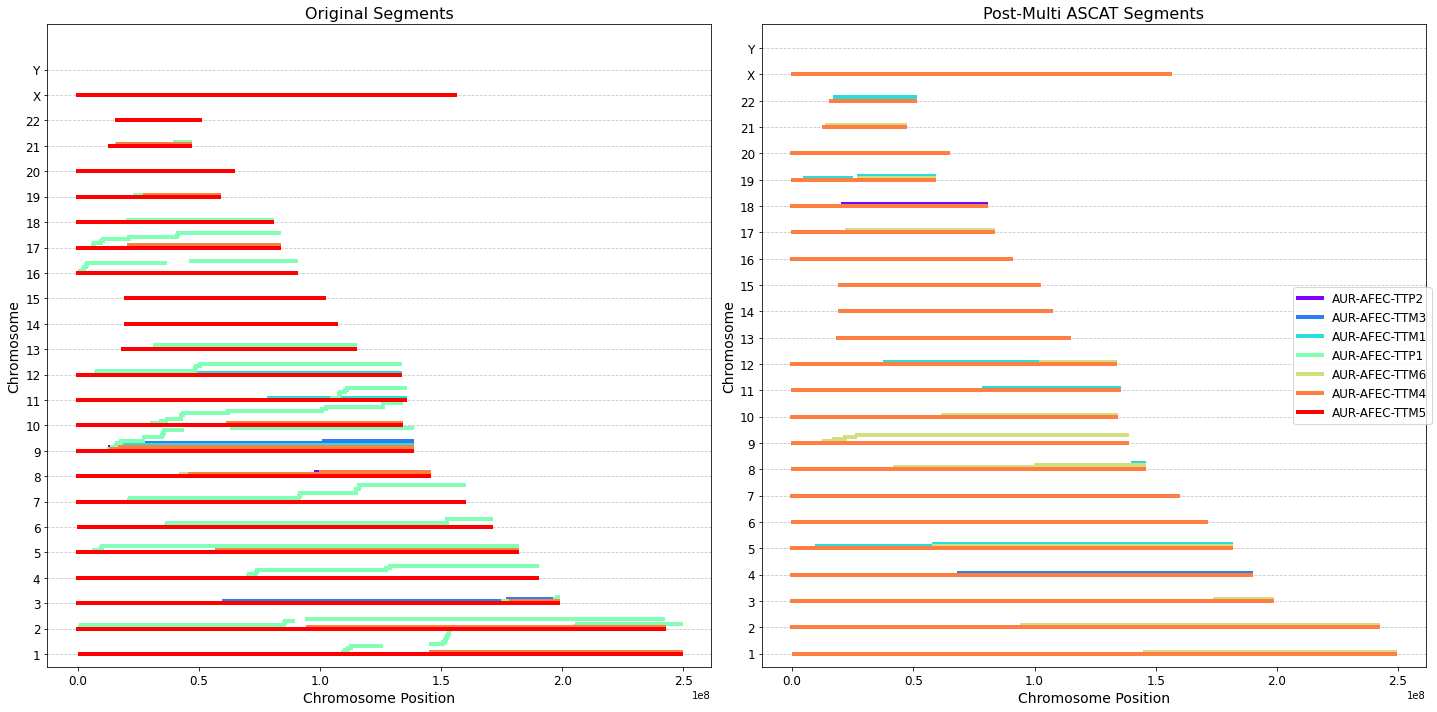

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_and_plot_segments(base_folder, multi_ascat_folder):
    # Function to read segment file
    def read_segment_file(file_path):
        df = pd.read_csv(file_path, sep='\t')
        # Convert chromosome to numeric, handling 'X' and 'Y'
        df['chr_num'] = df['chr'].replace({'X': 23, 'Y': 24}).astype(int)
        return df

    # Function to plot segments
    def plot_segments(ax, segments, colors):
        chr_heights = {i: [] for i in range(1, 25)}
        for sample, color in zip(segments, colors):
            height = {i: 0 for i in range(1, 25)}
            for _, row in sample.iterrows():
                chr_num = row['chr_num']
                start = row['startpos']
                end = row['endpos']
                y = chr_num + height[chr_num] * 0.08
                ax.plot([start, end], [y, y], color=color, linewidth=4)
                ax.vlines(start, y - 0.02, y + 0.02, color=color, linewidth=2)
                ax.vlines(end, y - 0.02, y + 0.02, color=color, linewidth=2)
                height[chr_num] += 1
                chr_heights[chr_num].append(height[chr_num])
        
        # Adjust y-limits based on the maximum height for each chromosome
        max_height = max(max(heights) if heights else 0 for heights in chr_heights.values())
        ax.set_ylim(0.5, 24.5 + max_height * 0.08)

    # Find original segment files
    original_segments = []
    original_sample_names = []
    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            segment_file = [f for f in os.listdir(subfolder_path) if f.endswith('.segments.txt')]
            if segment_file:
                file_path = os.path.join(subfolder_path, segment_file[0])
                original_segments.append(read_segment_file(file_path))
                original_sample_names.append(subfolder.split('_vs_')[0])

    # Find corresponding post-multi ASCAT segment files
    post_multi_segments = []
    for sample_name in original_sample_names:
        file_path = os.path.join(multi_ascat_folder, f"{sample_name}.segments.txt")
        if os.path.exists(file_path):
            post_multi_segments.append(read_segment_file(file_path))

    # Generate colors for each sample
    colors = plt.cm.rainbow(np.linspace(0, 1, len(original_segments)))

    # Plot original segments
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    plot_segments(ax1, original_segments, colors)
    ax1.set_title("Original Segments", fontsize=16)
    ax1.set_xlabel("Chromosome Position", fontsize=14)
    ax1.set_ylabel("Chromosome", fontsize=14)
    ax1.set_yticks(range(1, 25))
    ax1.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                         '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
                         '21', '22', 'X', 'Y'])
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

    # Plot post-multi ASCAT segments
    plot_segments(ax2, post_multi_segments, colors)
    ax2.set_title("Post-Multi ASCAT Segments", fontsize=16)
    ax2.set_xlabel("Chromosome Position", fontsize=14)
    ax2.set_ylabel("Chromosome", fontsize=14)
    ax2.set_yticks(range(1, 25))
    ax2.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                         '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
                         '21', '22', 'X', 'Y'])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

    # Add legend
    lines = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    fig.legend(lines, original_sample_names, loc='center right', fontsize=12)

    plt.tight_layout()
    plt.show()

    return fig
    
base_folder = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/AFEC_WES_results/variant_calling/ascat"
multi_ascat_folder = "/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/TUSV-ext/multi_ascat"

fig = compare_and_plot_segments(base_folder, multi_ascat_folder)

In [ ]:
# Now we need to write new code that incorporates post multi ascat results for CNAs instead. 

# Converting TUSV-ext output into interpretable target selection

In [ ]:
# Read in various matrices given - vague

# Convert Features and Genome Features, and create multiple forms of graph - make better graphs or modifiable ones

# Given a SV, CNA, or SNV ID, identify where it belongs on the tree. 

# Label the trees better
# Label the leaves


# Pipe SVs from TUSV-ext into AnnotSV - NOT NECESSARY JUST LOOK AT GENE SEGMENTS

# Detect if DELETIOSN are homozygous or heterozygous - DONE

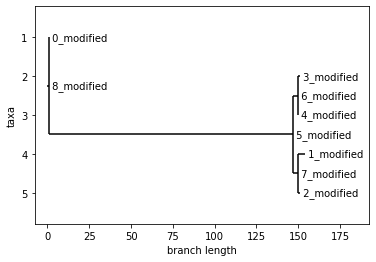

In [2]:
from Bio import Phylo
from Bio.Phylo.PhyloXML import Phylogeny

# Figure out where the branch labels are coming from

def read_xml(fname):
    # Read the phyloxml file
    tree = Phylo.read(fname, 'phyloxml')
    
    # Example: Modify the tree
    for clade in tree.find_clades():
        if clade.name:  # If the clade has a name, you can modify it
            clade.name = clade.name + "_modified"  # Example modification

    return tree

# Example usage
tree = read_xml('AFEC_test_output_gpu_wSVs/num_clone_5/unmixed.xml')

# You can now work with 'tree' and make further modifications
Phylo.draw(tree)  # If you want to visualize the tree


In [ ]:
from Bio import Entrez
import numpy as np
import pandas as pd
import sys

# Let NCBI know who you are
Entrez.email = "your email"

def get_full_refseq_ids(ucsc_refseq_annot_file,ref='hg19'):
    if ref=='hg38':
        column_names = [
        "Chromosome",
        "Start_position",
        "End_position",
        "Gene_Identifier",
        "Score",
        "Strand",
        "Thick_start",
        "Thick_end",
        "Item_RGB",
        "Block_count",
        "Block_sizes",
        "Block_starts"
        ]
        df = pd.read_csv(ucsc_refseq_annot_file,sep='\t',header=None, index_col=None,names=column_names)
    elif ref == 'hg19':
        df = pd.read_csv(ucsc_refseq_annot_file,sep='\t',index_col=None)
        
    return df

def get_W_chrom_pos(W,u,v, F_info): 
    ones = abs(W.iloc[u]-W.iloc[v])>=1
    ones_ind = ones[ones].index.tolist()
    
    return F_info.iloc[ones_ind]

def get_gene_name(refseq_id):
    handle = Entrez.efetch(db="nucleotide", id=refseq_id, retmode="xml")
    records = Entrez.read(handle)
    handle.close()
    try:
        for feature in records[0]['GBSeq_feature-table']:
            if feature['GBFeature_key'] == 'gene':
                for qualifier in feature['GBFeature_quals']:
                    if qualifier['GBQualifier_name'] == 'gene':
                        return qualifier['GBQualifier_value']
    except:
        return None

def get_one_refseq(refseq_full,chrom, pos,chr_col,st_col,end_col,var_type):
    
    chrom_str = 'chr'+str(chrom)
    if var_type =='snv_sv':
        matching_rows = refseq_full[
            refseq_full[chr_col].str.contains(chrom_str) &
            (refseq_full[st_col] <= pos) &
            (refseq_full[end_col] >= pos)
        ]
#    elif var_type=='cnv':
#        matching_rows = refseq_full[
#            refseq_full[chr_col].str.contains(chrom_str) &
#            (refseq_full[st_col] >= pos) &
#            (refseq_full[end_col] <= (pos+500000))
#        ]   
    
    
    return matching_rows

def get_one_gene(refseq_full,chrom, pos,chr_col,st_col,end_col):
    if chrom==23:
        chrom=' X'
    chrom_str = 'chr'+str(chrom)
    
        
    matching_rows = refseq_full[
        refseq_full[chr_col].str.contains(chrom_str) &
        (refseq_full[st_col] <= pos) &
        (refseq_full[end_col] >= pos)
    ]
    return matching_rows

def get_your_refseq_ids(refseq_full,chromes,pos,ref_genome,var_type):
    genes = []
    for i in range(len(chromes)):
        
        if ref_genome=='hg38':
            matching_rows = get_one_refseq(refseq_full,chromes[i],pos[i],'Chromosome','Start_position','End_position',var_type)
            refseq_ids = list(matching_rows['Gene_Identifier'])
            if len(refseq_ids) == 0:
                continue
            gene = get_gene_name(refseq_ids)
            
        elif ref_genome=='hg19':
            matching_rows = get_one_refseq(refseq_full,chromes[i],pos[i],'chrom','txStart','txEnd',var_type)
            
            gene = list(dict.fromkeys(matching_rows['name2'])) # set(list(matching_rows['name2']))
            if len(gene)!=0:
                genes.append(','.join(gene))
                
    return genes



def get_genes_in_edge(W,u,v,F_info,var_type):
    print('Finding genes...')
    ref_genome = 'hg19'
    refseq_full = get_full_refseq_ids('hgTables_ucsc_refseq_hg19.txt',ref_genome)
    
    chorms_pos = get_W_chrom_pos(W,u,v,F_info)
    chroms = list(chorms_pos['Chrom'])
    pos = list(chorms_pos['Pos'])
    
    genes_in_edge = get_your_refseq_ids(refseq_full,chroms,pos,ref_genome,var_type)
    
        
    print('Edge',u,v,genes_in_edge)
    return (u,v,genes_in_edge)

def save_genes(W,file,folder,var_type,F_info):
    #var_type='snv_sv'
    f = open(folder+'/'+file,'w')
    # this part should read all the edges from the tree one by one. 
    # Maybe update this part to read directly from the tree instead of hard-coding.. 
    u,v,genes = get_genes_in_edge(W,6,5,F_info,var_type)
    f.write('Edge '+str(u)+', '+str(v)+','.join(genes)+'\n')
    u,v,genes = get_genes_in_edge(W,5,4,F_info,var_type)
    f.write('Edge '+str(u)+', '+str(v)+','.join(genes)+'\n')
    u,v,genes = get_genes_in_edge(W,5,3,F_info,var_type)
    f.write('Edge '+str(u)+', '+str(v)+','.join(genes)+'\n')
    u,v,genes = get_genes_in_edge(W,6,1,F_info,var_type)
    f.write('Edge '+str(u)+', '+str(v)+','.join(genes)+'\n')
    u,v,genes = get_genes_in_edge(W,6,2,F_info,var_type)
    f.write('Edge '+str(u)+', '+str(v)+','.join(genes)+'\n')
    u,v,genes = get_genes_in_edge(W,6,0,F_info,var_type)
    f.write('Edge '+str(u)+', '+str(v)+','.join(genes)+'\n')
    f.close()

folder = sys.argv[1]
W = pd.read_csv(folder+'W.tsv',sep='\t',index_col=None,header=None) 
W_SV = pd.read_csv(folder+'W_SV.tsv',sep='\t',index_col=None,header=None)
F_info = pd.read_csv(folder+'F_info_phasing.csv',sep='\t',index_col=None,header=None).iloc[:W.shape[1]]
F_info.columns = ['Chrom','Pos','variant']
save_genes(W_SV,'genes_SV.txt',folder,'snv_sv',F_info)